# Named Entity Recognition using LSTMs with Keras

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/named-entity-recognition')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Import Libraries

In [2]:
%%capture

!pip install livelossplot
!pip install tensorflow==2.1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.1.0


### Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [6]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [7]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Retrieve Sentences and Corresponsing Tags

In [8]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [10]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define Mappings between Sentences and Tags

In [11]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
word2idx

{'re-build': 1,
 'concession': 2,
 'Amil': 3,
 'fours': 4,
 'eased': 5,
 'raged': 6,
 'Taliban-dominated': 7,
 'Asghari': 8,
 'abandon': 9,
 'picture': 10,
 'Shanghai-bound': 11,
 'Taipei': 12,
 '295': 13,
 'makeshift': 14,
 'exchanges': 15,
 'dumped': 16,
 'French-Spanish-Swiss': 17,
 'Serzh': 18,
 'Guenael': 19,
 '145': 20,
 'caption': 21,
 'inbalance': 22,
 'three-hour': 23,
 'Benigno': 24,
 'et': 25,
 'healed': 26,
 'Pointe': 27,
 'enemies': 28,
 'H.I.V.': 29,
 'appointing': 30,
 'pigeon': 31,
 'Toepfer': 32,
 'sugar': 33,
 'Rafsanjani': 34,
 'stalls': 35,
 'tract': 36,
 'Rusere': 37,
 'jumped': 38,
 'Kerry': 39,
 'stadium': 40,
 'Vietnam': 41,
 'Serious': 42,
 'concessional': 43,
 'Dunkin': 44,
 'warms': 45,
 'officer': 46,
 'Greeks': 47,
 'Belgaum': 48,
 'leave': 49,
 'Dale': 50,
 'Pro-Western': 51,
 'stems': 52,
 'ex-Beatle': 53,
 'distorts': 54,
 'mixed-race': 55,
 'Jixi-Nehe': 56,
 'hexaflouride': 57,
 'unequivocally': 58,
 'Jalgaon': 59,
 'restrain': 60,
 'poaching': 61,
 'Dr

### Padding Input Sentences and Creating Train/Test Splits

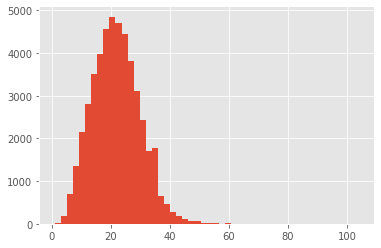

In [13]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Build and Compile a Bidirectional LSTM Model

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [17]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Train the Model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

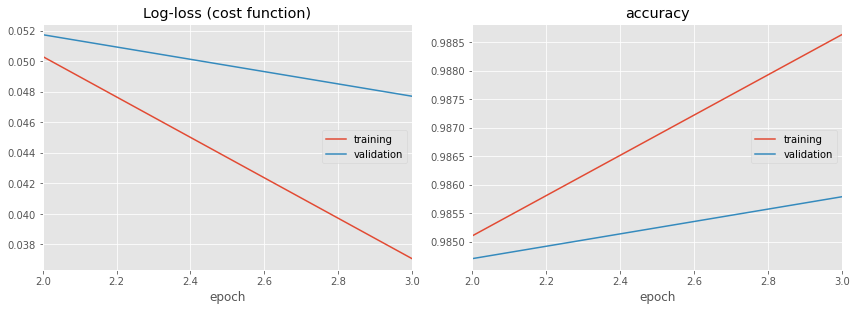

Log-loss (cost function):
training   (min:    0.037, max:    0.177, cur:    0.037)
validation (min:    0.048, max:    0.067, cur:    0.048)

accuracy:
training   (min:    0.959, max:    0.989, cur:    0.989)
validation (min:    0.981, max:    0.986, cur:    0.986)

Epoch 00003: val_loss improved from 0.05173 to 0.04770, saving model to model_weights.h5
38367/38367 [==============================] - 214s 6ms/sample - loss: 0.0371 - accuracy: 0.9886 - val_loss: 0.0477 - val_accuracy: 0.9858


In [20]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), checkpoint, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=1)

### Evaluate Named Entity Recognition Model

In [21]:
model.evaluate(x_test, y_test)

9592/9592 [==============================] - 10s 1ms/sample - loss: 0.0477 - accuracy: 0.9858


[0.04770135915247076, 0.98578817]

In [27]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
country        O	O
served         O	O
as             O	O
a              O	O
buffer         O	O
between        O	O
the            O	O
British        B-gpe	B-gpe
and            O	O
Russian        B-gpe	B-gpe
Empires        O	O
until          O	O
it             O	O
won            O	O
independence   O	O
from           O	O
notional       O	O
British        B-gpe	B-gpe
control        O	O
in             O	O
1919           B-tim	B-tim
.              O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O	O
Idriz          O